In [4]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import dewpoint_from_relative_humidity, most_unstable_cape_cin 
#I had some ideas that these other functions might have the answer, but I think I'm wrong.
#from metpy.calc import equivalent_potential_temperature, surface_based_cape_cin
from metpy.units import units
from itertools import product
from scipy.interpolate import interp1d

In [5]:
#ds=xr.merge([xr.open_dataset('cape_2010_july_01.nc'),xr.open_dataset('T_RH_2010_july_01.nc')])
ds=xr.merge([xr.open_dataset('single_lev_2010_07_01_12.nc'),xr.open_dataset('pressure_levs_2010_07_01_12.nc')])
#subsample so that we can do the CAPE calculations quicker and do some testing
ds=ds.isel(time=0,level=slice(None,None,-1),longitude=slice(None,None,5),latitude=slice(None,None,5))

lat=ds.latitude
ny=len(lat)
lon=ds.longitude
nx=len(lon)
p=ds.level*units.hPa 
nz=len(p)

print(nx,ny,nz)

41 21 37


In [6]:
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, level: 37)
Coordinates:
  * longitude  (longitude) float32 -120.0 -118.8 -117.5 ... -72.5 -71.25 -70.0
  * latitude   (latitude) float32 50.0 48.75 47.5 46.25 ... 27.5 26.25 25.0
    time       datetime64[ns] 2010-07-01T12:00:00
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
Data variables:
    d2m        (latitude, longitude) float32 ...
    t2m        (latitude, longitude) float32 ...
    cape       (latitude, longitude) float32 ...
    sp         (latitude, longitude) float32 ...
    r          (level, latitude, longitude) float32 ...
    q          (level, latitude, longitude) float32 ...
    t          (level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-16 02:47:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


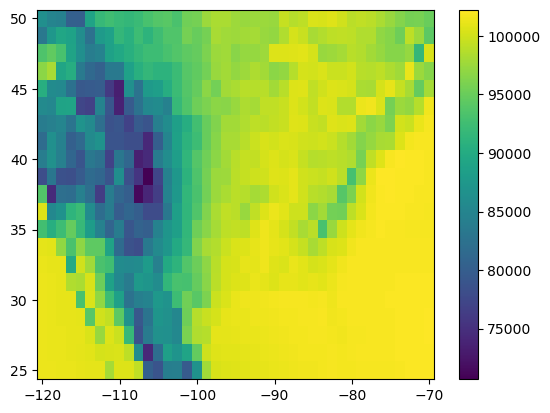

In [8]:
plt.pcolor(lon,lat,ds.sp)
plt.colorbar()

In [9]:
#I'm too lazy to work out how to do the units now, so just store as an array 
MC=np.zeros([ny,nx]) 
MCm=np.zeros([ny,nx]) 
MCs=np.zeros([ny,nx])

#finer grid to intepolate to, in hPa
pi=np.arange(1e3,0,-1)*units.hPa

for iy,ix in product(range(0,len(lat)),range(0,len(lon))):

    T=ds.t[:,iy,ix]
    R=ds.r[:,iy,ix]
    Td=dewpoint_from_relative_humidity(T, R)

    #normal calculation
    MC[iy,ix]=most_unstable_cape_cin(p, T, Td)[0].magnitude


    #try to implement some masking of pressure levels below the surface 
    #be careful to set the units of the surface pressure correctly
    ps=ds.sp[iy,ix]*0.01*units.hPa
    if ps>=p[0]:
        #if the surface pressure is below the bottom level ignore
        ip=None
    else:
        #otherwise find first level above ground
        ip=np.min(np.where(p<=ps.data))
    MCm[iy,ix]=most_unstable_cape_cin(p[ip:], T[ip:], Td[ip:])[0].magnitude


    #try to append the surface data and see if it improves anything
"""     
    ps=ds.sp[iy,ix]*0.01*units.hPa
    if ps>=p[0]:
        #if the surface pressure is below the bottom level ignore
        ptemp=np.hstack([ps,p])*units.hPa
        ttemp=np.hstack([ds.t2m[iy,ix].data,T])*units.K
        dtemp=np.hstack([(ds.d2m[iy,ix].data-273.15),Td])*units.degC
#        ip=None
    else:
        #otherwise find first level above ground
        ip=np.min(np.where(p<ps.data))
        ptemp=np.hstack([ps,p[ip:]])*units.hPa
        ttemp=np.hstack([ds.t2m[iy,ix].data,T[ip:]])*units.K
        dtemp=np.hstack([(ds.d2m[iy,ix].data-273.15),Td[ip:]])*units.degC
    MCs[iy,ix]=most_unstable_cape_cin(ptemp, ttemp, dtemp)[0].magnitude
 """

    #metpy doesn't know what to do with supersaturated values, so lets take them out.
"""     if np.max(R[ip:]>100):
        R100=np.copy(R[ip:])
        R100[R100>100]=100
        R100*=units.percent
        Td100=dewpoint_from_relative_humidity(T[ip:], R100)
        MCs[iy,ix]=most_unstable_cape_cin(p[ip:], T[ip:], Td100)[0].magnitude
    else:
        MCs[iy,ix]=MCm[iy,ix]
 """
    #first interpolate to a finer grid, then do the masked calculation
    #be careful to set the units of the intepolated data
""" 
    Ti=interp1d(x=lev.data,y=ds.t[:,iy,ix].data,kind='cubic')(pi)*units.K
    Ri=interp1d(x=lev.data,y=ds.r[:,iy,ix].data,kind='cubic')(pi)*units.percent 
    ps=ds.sp[iy,ix]*0.01*units.hPa
    if ps>=pi[0]:
        ipi=None
    else:
        ipi=np.min(np.where(pi<=ps.data))
    MCmi[iy,ix]=most_unstable_cape_cin(pi[ipi:], Ti[ipi:], dewpoint_from_relative_humidity(Ti[ipi:], Ri[ipi:]))[0].magnitude
"""

/home/rfajber/m3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/rfajber/m3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/rfajber/m3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/rfajber/m3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/rfajber/m3/lib/python3.9/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: invalid value encountered in log
  v

" \n    Ti=interp1d(x=lev.data,y=ds.t[:,iy,ix].data,kind='cubic')(pi)*units.K\n    Ri=interp1d(x=lev.data,y=ds.r[:,iy,ix].data,kind='cubic')(pi)*units.percent \n    ps=ds.sp[iy,ix]*0.01*units.hPa\n    if ps>=pi[0]:\n        ipi=None\n    else:\n        ipi=np.min(np.where(pi<=ps.data))\n    MCmi[iy,ix]=most_unstable_cape_cin(pi[ipi:], Ti[ipi:], dewpoint_from_relative_humidity(Ti[ipi:], Ri[ipi:]))[0].magnitude\n"

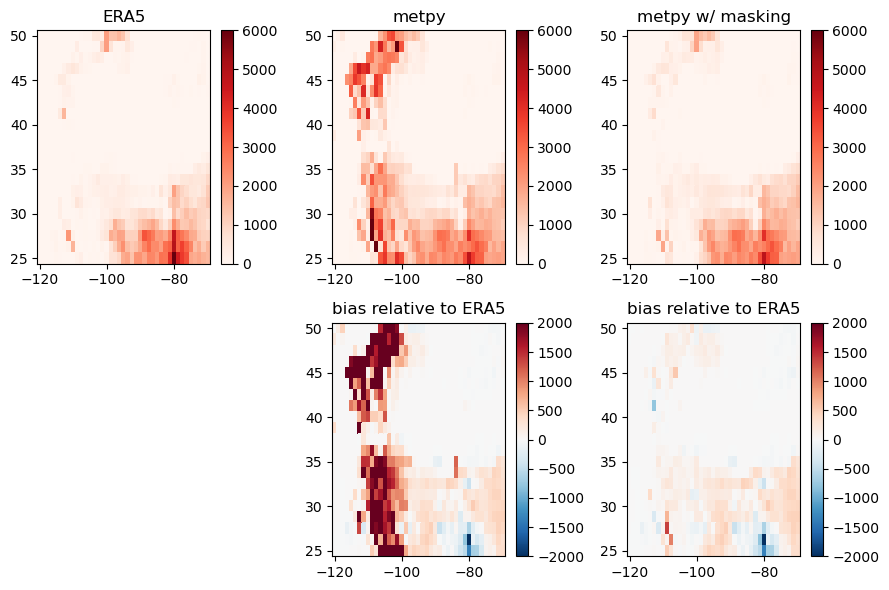

In [10]:
vars=[ds.cape,MC,MCm,MC-ds.cape,MCm-ds.cape]
inds=[1,2,3,5,6]
titles=['ERA5','metpy','metpy w/ masking','bias relative to ERA5','bias relative to ERA5']
plt.figure(0,figsize=(9,6))
for i,v in enumerate(vars):
    plt.subplot(2,3,inds[i])
    if i<=2:
        cmap=plt.cm.Reds
        vmin=0
        vmax=6000
    else:
        cmap=plt.cm.RdBu_r
        vmin=-2000
        vmax=2000
    plt.pcolor(lon,lat,v,
                vmin=vmin,vmax=vmax,cmap=cmap)
    plt.title(titles[i])
    plt.colorbar()
plt.tight_layout()